In [1]:
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.metrics import ConfusionMatrixDisplay
import os
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression

from metrics import get_acc, get_jsd, get_auc, add_preds, acc_buckets, get_kappa_mcqs, get_diffp, populate_preds, precomputed_accs, precomputed_diffs
# Wrap the original function
original_get_kappa_mcqs = get_kappa_mcqs

# Redefine get_kappa_mcqs to always include n_options=2
def get_kappa_mcqs(*args, **kwargs):
    return original_get_kappa_mcqs(*args, n_options=2, **kwargs)


/is/sg2/sgoel/miniconda3/envs/diff/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preds = {}
folder_name = "epochs_3"
model_names = ["weak_ft", "strong_base", "mean", "w2s", "strong_ft", "diff_ceil"]
model_names = ["weak_ft", "strong_base", "w2s", "strong_ft"]
weak_model, strong_model = "phi-2", "Qwen2.5-7B"
datasets = ["anli-r2", "boolq", "cola", "ethics-utilitarianism", "sciq", "piqa", "sst2", "twitter-sentiment"]
# datasplits = ["train", "val", "test"]
datasplits = ["test"]

#ALT CONFIG
# model_names = ["weak_ft", "strong_ft", "w2s"]
# shared_name = "shared3"
# test_name = "test3"

preds = populate_preds(preds, datasets, model_names, datasplits, folder_name, weak_model, strong_model)


### Accuracies of the models across datasets -- grouped bar plot

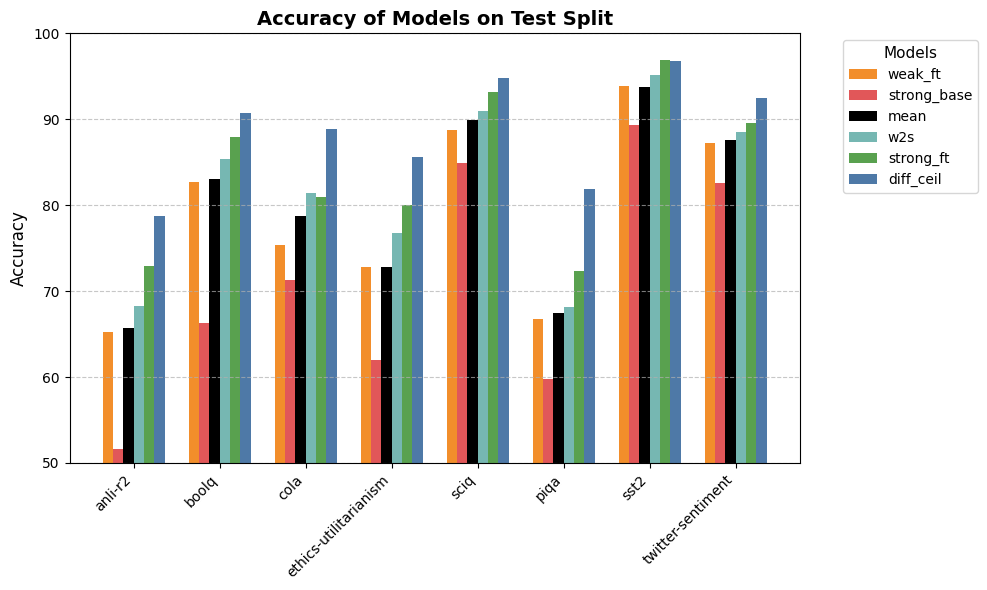

In [12]:
def grouped_bar_plot_accs(preds, split='test', metric="acc"):
    fig, ax = plt.subplots(figsize=(10, 6))
    barWidth = 0.12  # Narrower bars for better spacing
    r = range(len(datasets))
    
    # Define colors for each model
    colors = ['#f28e2b', '#e15759', '#000000', '#76b7b2', '#59a14f', '#4e79a7']
    
    metric_name, metric_func = "Accuracy", get_acc
    if metric=="auc":
        metric_name, metric_func = "ROC-AUC", get_auc
    
    for i, mname in enumerate(model_names):
        accs = [get_acc(preds[dname][mname][split]) for dname in datasets]
        ax.bar([x + barWidth * i for x in r], accs, width=barWidth, color=colors[i], label=mname)
    
    # Customize ticks and labels
    ax.set_xticks([x + barWidth * (len(model_names) - 1) / 2 for x in r])
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=10)
    ax.set_yticks(range(0, 110, 10))
    
    # Set labels and title with larger font sizes
    ax.set_ylabel(metric_name, fontsize=12)
    ax.set_title(f"{metric_name} of Models on {split.capitalize()} Split", fontsize=14, fontweight='bold')
    ax.set_ylim(50, 100)
    
    # Add grid lines for y-axis
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Move legend outside of the plot
    ax.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize='11')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function
grouped_bar_plot_accs(preds, split='test', metric="acc")

{'cc': {'correct': 1974, 'total': 2112}, 'cw': {'correct': 1509, 'total': 1632}, 'wc': {'correct': 304, 'total': 563}, 'ww': {'correct': 325, 'total': 693}}
{'cc': {'correct': 213, 'total': 231}, 'cw': {'correct': 138, 'total': 168}, 'wc': {'correct': 51, 'total': 114}, 'ww': {'correct': 27, 'total': 155}}
{'cc': {'correct': 1369, 'total': 1422}, 'cw': {'correct': 414, 'total': 486}, 'wc': {'correct': 128, 'total': 219}, 'ww': {'correct': 101, 'total': 347}}
{'cc': {'correct': 359, 'total': 369}, 'cw': {'correct': 89, 'total': 127}, 'wc': {'correct': 61, 'total': 90}, 'ww': {'correct': 15, 'total': 58}}
{'cc': {'correct': 1711, 'total': 1844}, 'cw': {'correct': 677, 'total': 859}, 'wc': {'correct': 379, 'total': 736}, 'ww': {'correct': 253, 'total': 727}}
{'cc': {'correct': 2273, 'total': 2324}, 'cw': {'correct': 228, 'total': 292}, 'wc': {'correct': 147, 'total': 205}, 'ww': {'correct': 50, 'total': 159}}
{'cc': {'correct': 645, 'total': 757}, 'cw': {'correct': 253, 'total': 356}, 'wc

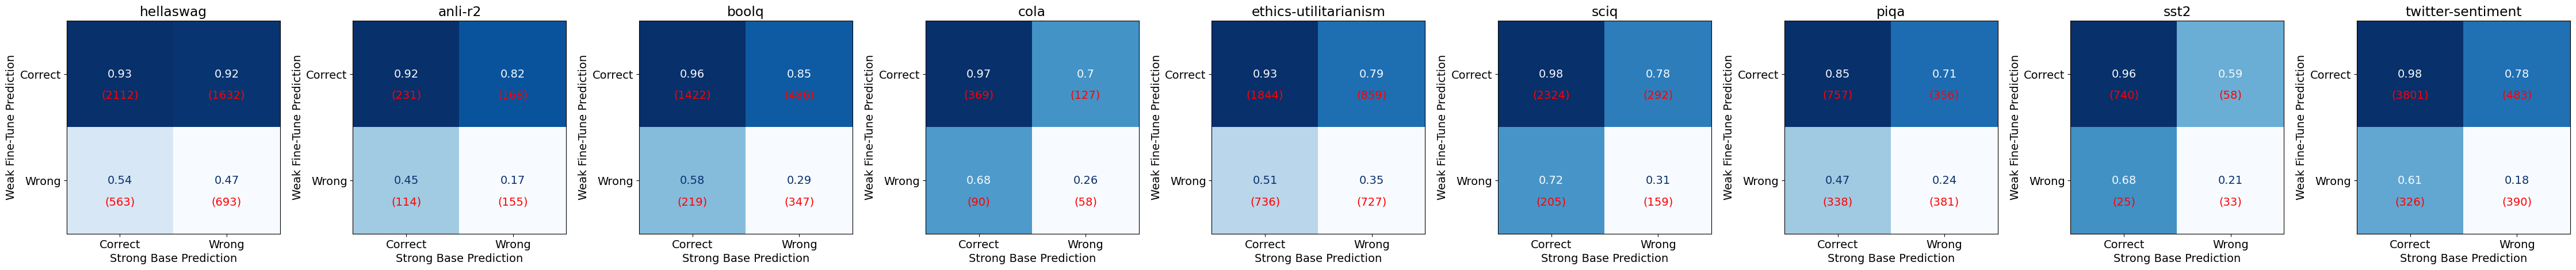

In [22]:
# confusion matrix of weak_ft, strong_base with accuracies of w2s printed in each square along with totals

def conf_mat_accs(preds, split='test'):
    num_datasets = len(preds)
    plt.rcParams.update({'font.size': 14})
    fig, axes = plt.subplots(1, num_datasets, figsize=(5 * num_datasets, 5))
    
    # Loop through each dataset and its corresponding axis for subplots
    for idx, (dset, ax) in enumerate(zip(preds, axes)):
        dsref1, dsref2, dsmain = preds[dset]["weak_ft"][split], preds[dset]["strong_base"][split], preds[dset]["w2s"][split]
        
        # Calculate accuracy buckets
        buckets = acc_buckets(dsref1, dsref2, dsmain)
        
        # Extract correct and total values
        correct_cc, total_cc = buckets['cc']['correct'], buckets['cc']['total']
        correct_cw, total_cw = buckets['cw']['correct'], buckets['cw']['total']
        correct_wc, total_wc = buckets['wc']['correct'], buckets['wc']['total']
        correct_ww, total_ww = buckets['ww']['correct'], buckets['ww']['total']
        
        # Normalized confusion matrix
        cm = np.array([
            [correct_cc / total_cc if total_cc > 0 else 0, correct_cw / total_cw if total_cw > 0 else 0],
            [correct_wc / total_wc if total_wc > 0 else 0, correct_ww / total_ww if total_ww > 0 else 0]
        ])
        
        # Create text annotations with only total count in brackets
        cm_text = np.array([
            [f"({total_cc})" if total_cc > 0 else "",
             f"({total_cw})" if total_cw > 0 else ""],
            [f"({total_wc})" if total_wc > 0 else "",
             f"({total_ww})" if total_ww > 0 else ""]
        ])
        
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Correct", "Wrong"])
        disp.plot(ax=ax, cmap="Blues", colorbar=False)
        
        # Add custom text annotations slightly below default text
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i + 0.2, cm_text[i, j], ha="center", va="center", color="red")  # Offset y-position slightly

        # Set dataset title and custom axis labels
        ax.set_title(dset)
        ax.set_xlabel("Strong Base Prediction", fontsize=14)
        ax.set_ylabel("Weak Fine-Tune Prediction", fontsize=14)
        plt.rcParams.update({'axes.labelsize': 14})
        plt.tick_params(axis='both', which='major', labelsize=14)

    
    # Adjust layout to fit all subplots well
    plt.tight_layout()
    plt.show()

# Run the function with your data
conf_mat_accs(preds, split='test')


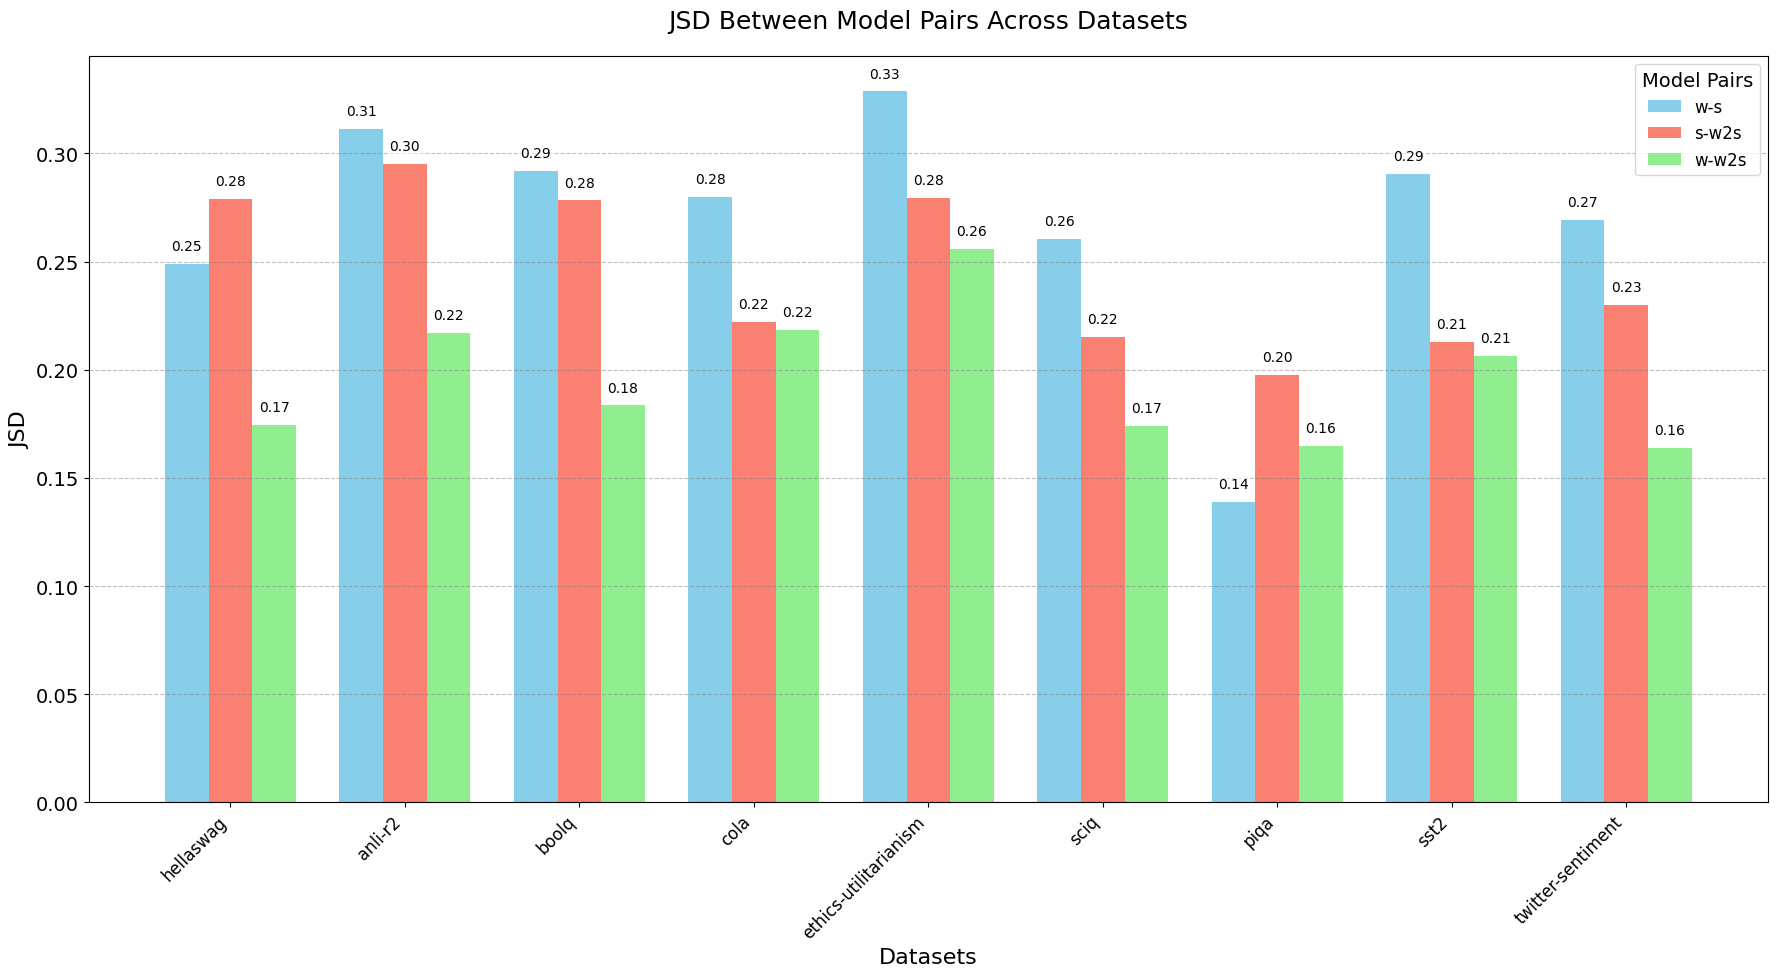

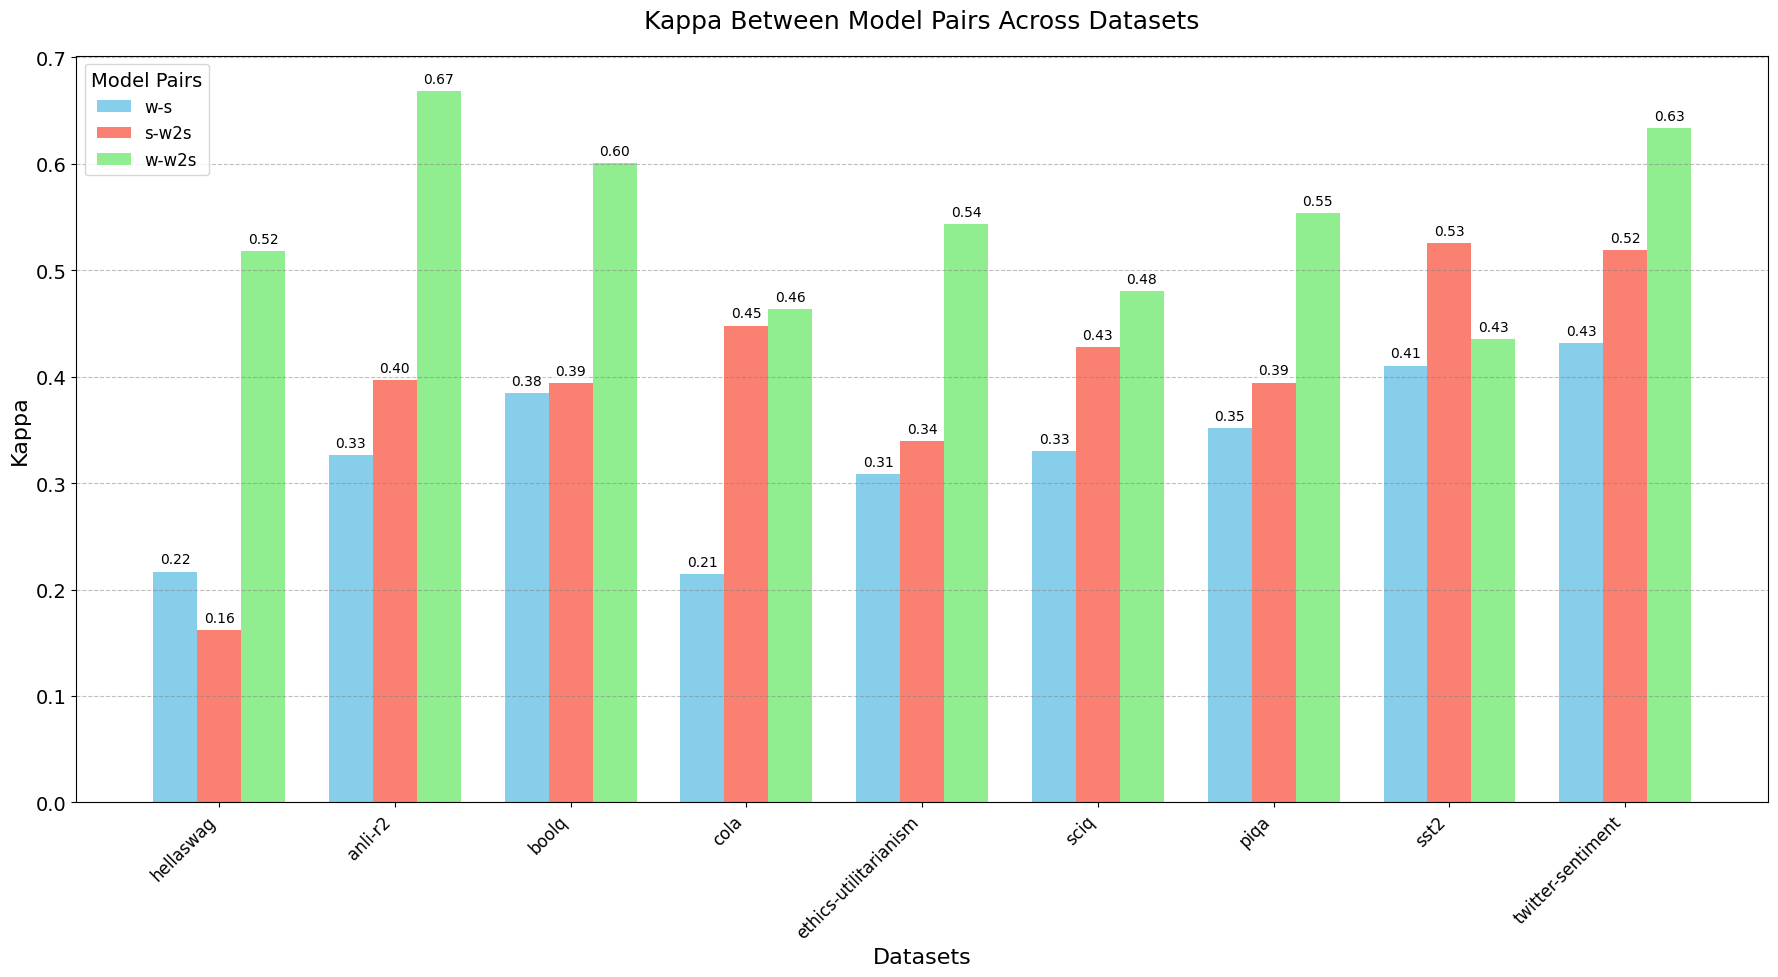

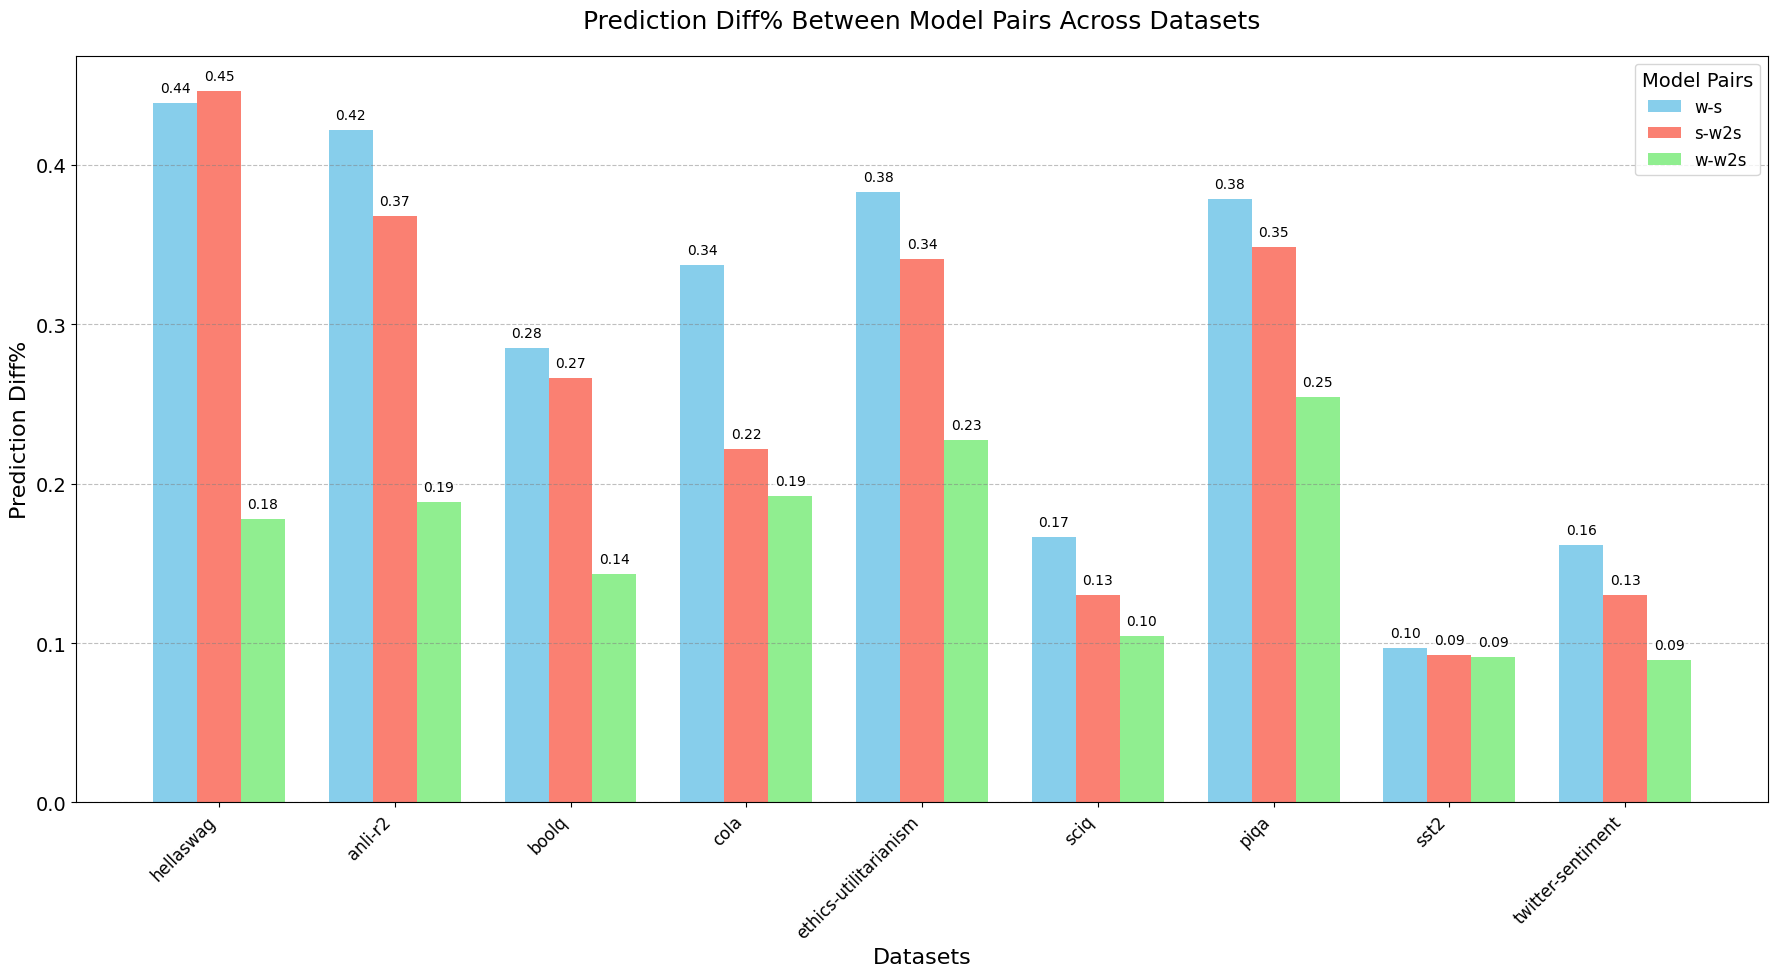

In [23]:
# plot diff metrics: jsd, pred-diff%, kappa vs accuracy gain of w2s model scatter plot across models and datasets
def plot_diff_metric(preds, datasets, metric_func, metric_name, m1name, m2name, m3name, split='test'):
    """
    Plots a grouped bar plot for a given metric across multiple datasets.

    Parameters:
    - preds: Dictionary containing predictions for multiple datasets.
                  Format: dset_preds[dataset][model_name]][split] = prediction_array
    - datasets: List of dataset names.
    - metric_func: Function to calculate the metric (e.g., get_jsd).
    - metric_name: Name of the metric (e.g., "JSD").
    - m1name, m2name, m3name: Names of the three models.
    """
    # Define model pairs and their labels
    model_pairs = [ (m1name, m2name), (m2name, m3name), (m1name, m3name) ]
    pair_labels = ["w-s", "s-w2s", "w-w2s"]
    num_pairs = len(model_pairs)
    x = np.arange(len(datasets))  # Label locations
    width = 0.25  # Width of each bar

    # Initialize lists to hold metric values for each pair
    metrics_per_pair = { label: [] for label in pair_labels }

    # Collect metrics for each model pair across all datasets
    for dset in datasets:
        curr_preds = preds[dset]
        metrics_per_pair["w-s"].append(metric_func(curr_preds[m1name][split], curr_preds[m2name][split]))
        metrics_per_pair["s-w2s"].append(metric_func(curr_preds[m2name][split], curr_preds[m3name][split]))
        metrics_per_pair["w-w2s"].append(metric_func(curr_preds[m1name][split], curr_preds[m3name][split]))

    # Define colors for each model pair
    colors = ['skyblue', 'salmon', 'lightgreen']

    # Create the plot
    fig, ax = plt.subplots(figsize=(18, 10))

    # Plot each model pair's metrics as a separate bar set
    for i, label in enumerate(pair_labels):
        # Offset positions for each pair
        offset = (i - 1) * width  # Positions: -width, 0, +width
        bars = ax.bar(x + offset, metrics_per_pair[label], width, label=label, color=colors[i])

        # Annotate each bar with its height
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, 
                    bar.get_height() + 0.005,  # Slightly above the bar
                    f'{height:.2f}', 
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

    # Add labels, title, and custom x-axis tick labels, etc.
    ax.set_xlabel('Datasets', fontsize=16)
    ax.set_ylabel(metric_name, fontsize=16)
    ax.set_title(f'{metric_name} Between Model Pairs Across Datasets', fontsize=18, pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=12)
    ax.legend(title='Model Pairs', fontsize=12, title_fontsize=14)

    # Add gridlines for better readability
    ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

    # Tight layout to accommodate labels and annotations
    plt.tight_layout()
    plt.show()

plot_diff_metric(preds, datasets, get_jsd, "JSD", "weak_ft", "strong_base", "w2s", split='test')
plot_diff_metric(preds, datasets, get_kappa_mcqs, "Kappa", "weak_ft", "strong_base", "w2s", split='test')
plot_diff_metric(preds, datasets, get_diffp, "Prediction Diff%", "weak_ft", "strong_base", "w2s", split='test')

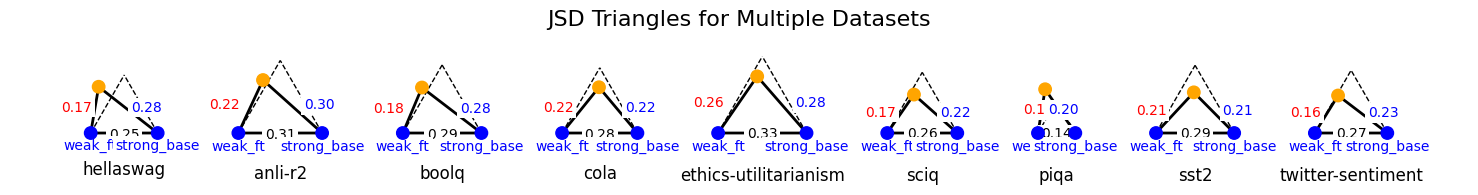

In [24]:
# jsd visualized as triangles

def plot_multiple_triangles(preds, datasets, m1name, m2name, m3name, padding=0.5, split='test'):
    """
    Plots triangles for multiple datasets, where each triangle's sides correspond to JSD values.
    
    Parameters:
    - dset_preds: Dictionary containing predictions for multiple datasets.
    - datasets: List of dataset names.
    - m1name, m2name, m3name: Names of the three models.
    - padding: Horizontal space between consecutive triangles.
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    current_x = 0  # Starting x-coordinate for the first triangle
    max_y = 0      # To adjust y-axis limits

    for dset in datasets:
        dsref1 = preds[dset][m1name][split]
        dsref2 = preds[dset][m2name][split]
        dsmain = preds[dset][m3name][split]
        jsd_1_2 = get_jsd(dsref1, dsref2)
        jsd_1_3 = get_jsd(dsref1, dsmain)
        jsd_2_3 = get_jsd(dsref2, dsmain)

        # Check if the sides can form a valid triangle
        sides = [jsd_1_2, jsd_1_3, jsd_2_3]
        if any(s <= 0 for s in sides):
            print(f"Skipping {dset}: JSD values must be positive.")
            continue
        if not (sides[0] + sides[1] > sides[2] and
                sides[1] + sides[2] > sides[0] and
                sides[0] + sides[2] > sides[1]):
            print(f"Skipping {dset}: JSD values do not satisfy the triangle inequality.")
            continue

        # Base coordinates
        p1 = np.array([current_x, 0])
        p2 = np.array([current_x + jsd_1_2, 0])

        # Apex coordinates
        c = jsd_1_2
        a = jsd_1_3
        b = jsd_2_3

        x3 = (a**2 - b**2 + c**2) / (2 * c)
        y3_squared = a**2 - x3**2
        if y3_squared < 0:
            print(f"Skipping {dset}: Cannot compute triangle coordinates.")
            continue
        y3 = np.sqrt(y3_squared)
        p3 = np.array([current_x + x3, y3])

        # Update max_y for plot limits
        max_y = max(max_y, y3)

        # Plot the actual triangle
        triangle = np.array([p1, p2, p3, p1])
        ax.plot(triangle[:, 0], triangle[:, 1], 'k-', linewidth=2)

        # Scatter points for models
        ax.scatter([p1[0], p2[0], p3[0]],
                   [p1[1], p2[1], p3[1]],
                   color=['blue', 'blue', 'orange'], zorder=5, s=80)

        # *** Add the imaginary equilateral triangle apex and dashed lines ***
        # Calculate coordinates of the imaginary equilateral apex point (p3_eq)
        center_x_eq = (p1[0] + p2[0]) / 2
        h_eq = (np.sqrt(3) / 2) * c
        p3_eq = np.array([center_x_eq, h_eq])

        # Draw dashed lines from p1 and p2 to p3_eq
        ax.plot([p1[0], p3_eq[0]], [p1[1], p3_eq[1]], 'k--', linewidth=1)
        ax.plot([p2[0], p3_eq[0]], [p2[1], p3_eq[1]], 'k--', linewidth=1)

        # Optionally, plot the imaginary apex point
        # ax.scatter(p3_eq[0], p3_eq[1], color='grey', marker='x', s=80)

        # Adjusted positions and styles to prevent overlapping text

        # Annotate JSD values with increased offsets and background boxes
        mid_p1_p2 = (p1 + p2) / 2
        ax.text(mid_p1_p2[0], mid_p1_p2[1] + 0.1 * max_y, f"{jsd_1_2:.2f}",
                ha='center', va='top', fontsize=10,
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        mid_p1_p3 = (p1 + p3) / 2
        ax.text(mid_p1_p3[0] - 0.5 * c, mid_p1_p3[1] - 0.1 * max_y, f"{jsd_1_3:.2f}",
                ha='left', va='bottom', fontsize=10, color='red',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        mid_p2_p3 = (p2 + p3) / 2
        ax.text(mid_p2_p3[0] + 0.5 * c, mid_p2_p3[1] - 0.1 * max_y, f"{jsd_2_3:.2f}",
                ha='right', va='bottom', fontsize=10, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # Model labels with increased offsets and background boxes
        ax.text(p1[0], p1[1] - 0.12 * max_y, m1name, ha='center', va='top', fontsize=10, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        ax.text(p2[0], p2[1] - 0.12 * max_y, m2name, ha='center', va='top', fontsize=10, color='blue',
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # ax.text(p3[0] + p3[0] - p3_eq[0], p3[1] + 0.1 * max_y, m3name, ha='center', va='bottom', fontsize=10, color='orange',
        #         bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # Dataset label with increased offset and background box
        center_x = (p1[0] + p2[0]) / 2
        ax.text(center_x, -0.6 * max_y, dset, ha='center', va='top', fontsize=12,
                bbox=dict(facecolor='white', edgecolor='none', pad=2))

        # Update current_x for next triangle
        current_x = p2[0] + padding

    # Adjust plot limits to provide more space
    ax.set_xlim(-padding, current_x)
    ax.set_ylim(-0.25 * max_y, max_y * 1.4)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.title("JSD Triangles for Multiple Datasets", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

plot_multiple_triangles(preds, datasets, "weak_ft", "strong_base", "w2s", padding=0.3, split='test')

In [24]:
def make_scatter_plot(diff, w2sgain, labels, diff_func_name):
    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(diff, w2sgain, color='blue', s=50, alpha=0.7, edgecolors='w', linewidth=0.5)
    
    # Add labels to each point
    for i, label in enumerate(labels):
        plt.text(diff[i], w2sgain[i] + 0.1, label, fontsize=9, ha='center', va='bottom')
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(diff, w2sgain)
    
    # Generate values for the best fit line
    x_vals = np.array(plt.gca().get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=2, label=f'Best Fit Line')
    
    # Labels and title
    plt.xlabel(f"{diff_func_name} between weak_ft and strong_base", fontsize=12)
    plt.ylabel("Accuracy Gain of w2s over weak_ft", fontsize=12)
    plt.title(f"Accuracy Gain of w2s vs. {diff_func_name} between weak_ft and strong_base", fontsize=14)
    
    # Add grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Annotate statistical information
    plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nR²: {r_value**2:.2f}\nP-value: {p_value:.3e}',
             transform=plt.gca().transAxes,
             fontsize=10,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    
    # Add legend
    plt.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()

def scatter_diff_w2sgain(accs, diffs, datasets, m_weak, m_strong_ft, m_w2s, w2sgain=[], diff=[], labels=[], pgr=False):
    for dset in datasets:
        metric_num = accs[dset][m_w2s] - accs[dset][m_weak]
        metric_denom = accs[dset][m_strong_ft] - accs[dset][m_weak]
        if not pgr: metric_denom = 1 #comment for pgr
        w2sgain.append(metric_num / metric_denom if metric_denom != 0 else 0)
        diff.append(diffs[dset])
        labels.append(dset)
    return w2sgain, diff, labels

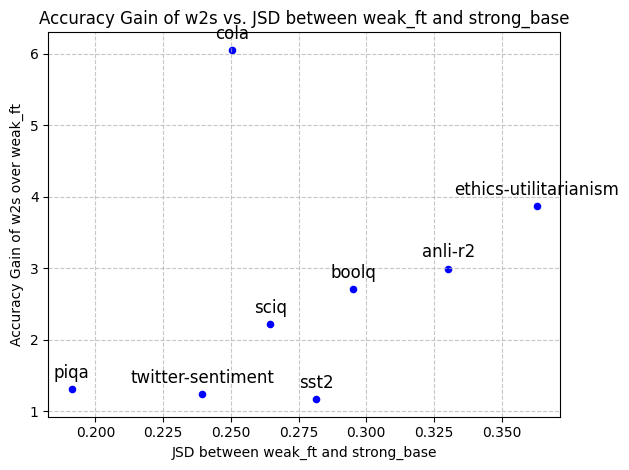

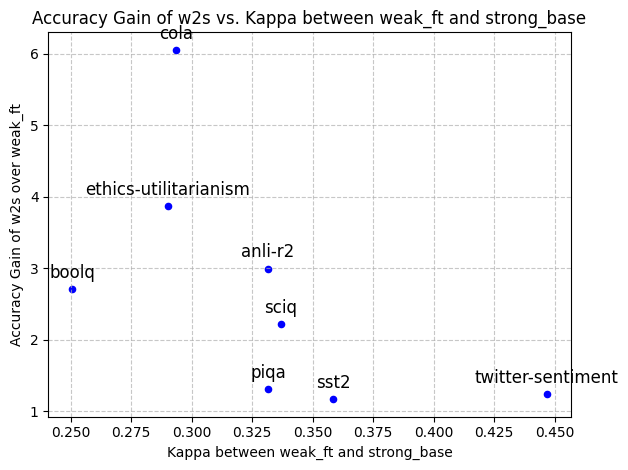

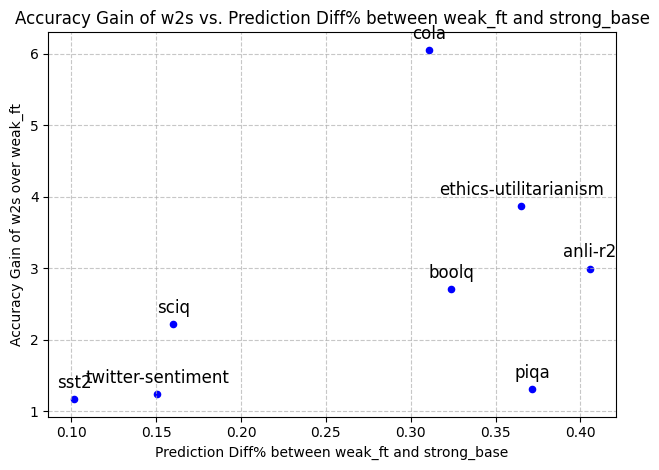

In [20]:
acc_test = {dset : precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
jsd_test = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, "test", get_jsd, "JSD") for dset in datasets}
kappa_test = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, "test", get_kappa_mcqs, "Kappa") for dset in datasets}
diffp_test = {dset : precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, "test", get_diffp, "diff-pred%") for dset in datasets}
mnames_scatter = ["weak_ft", "strong_base", "strong_ft", "w2s"]

for diffs, metric_name in zip([jsd_test, kappa_test, diffp_test], ["JSD", "Kappa", "Prediction Diff%"]):
    w2sgain, diff, labels = [], [], []
    w2sgain, diff, labels = scatter_diff_w2sgain(acc_test, diffs, datasets, "weak_ft", "strong_ft", "w2s", w2sgain, diff, labels)
    make_scatter_plot(diff, w2sgain, labels, metric_name)

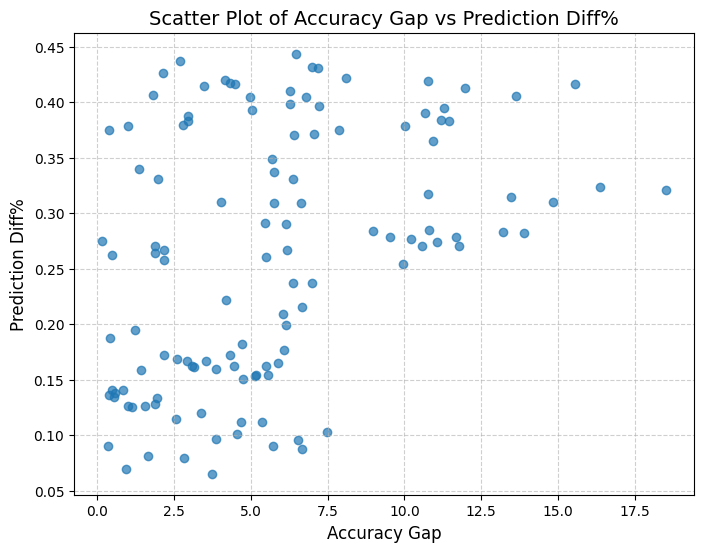

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


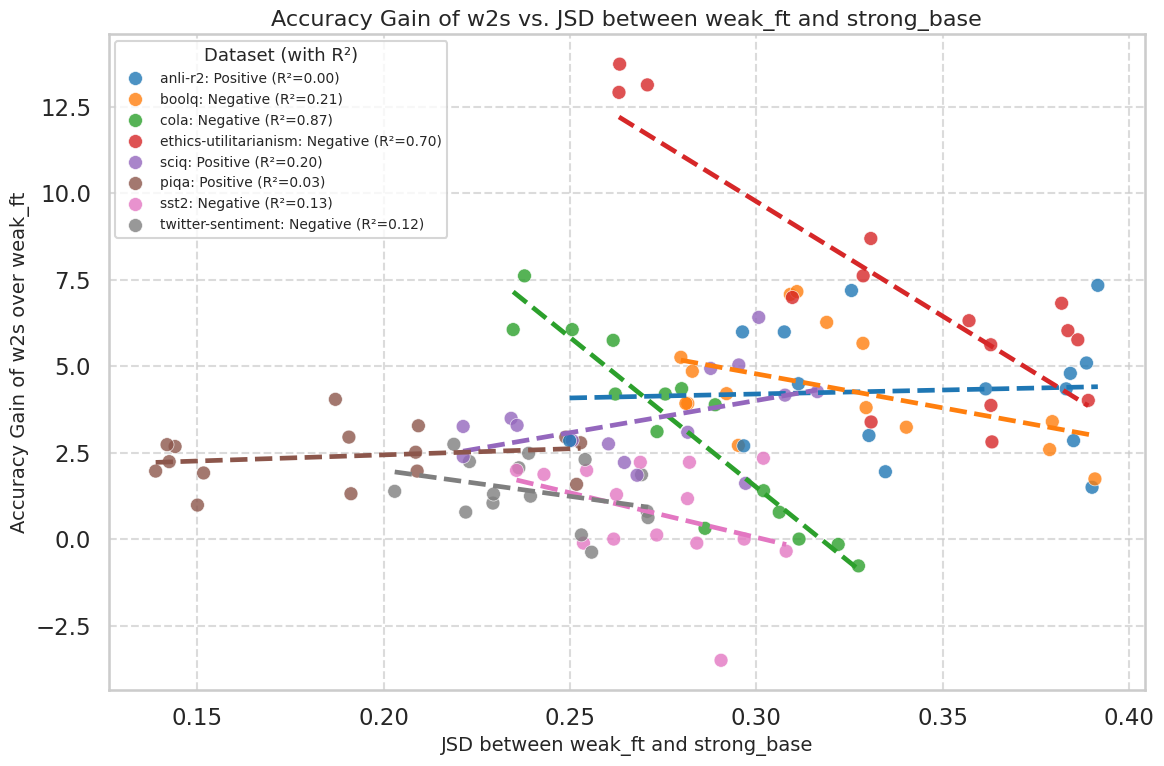

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


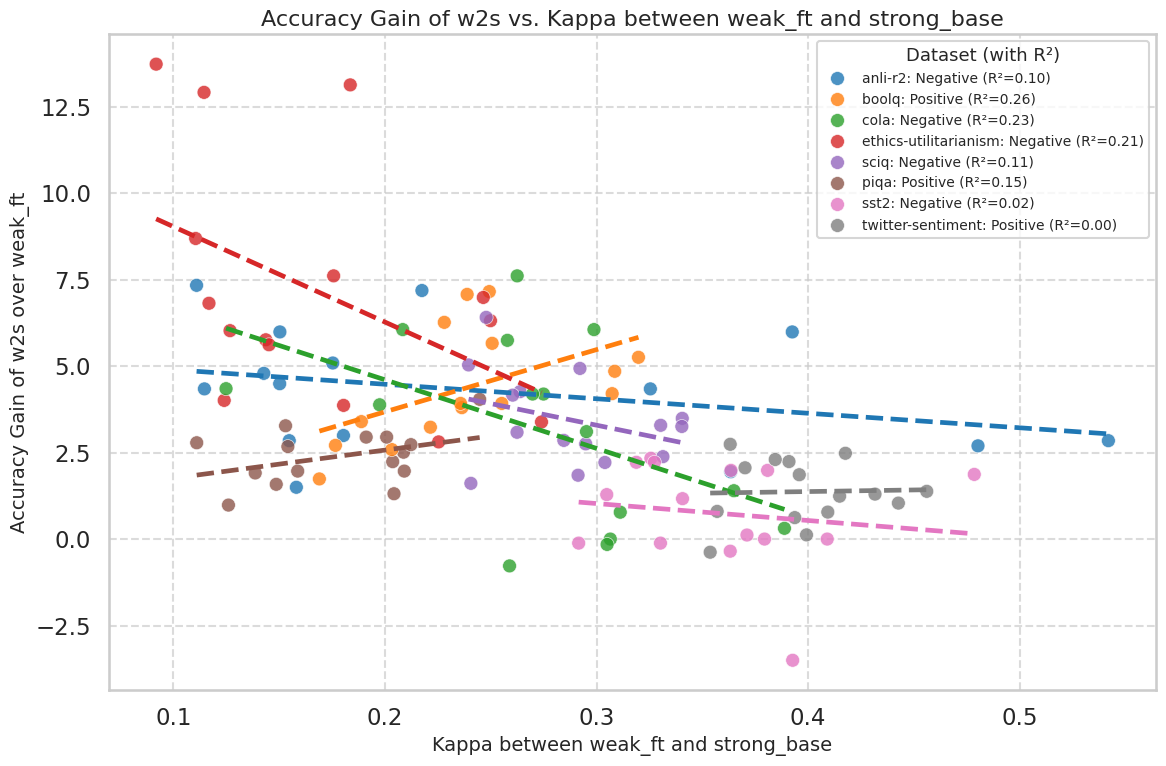

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


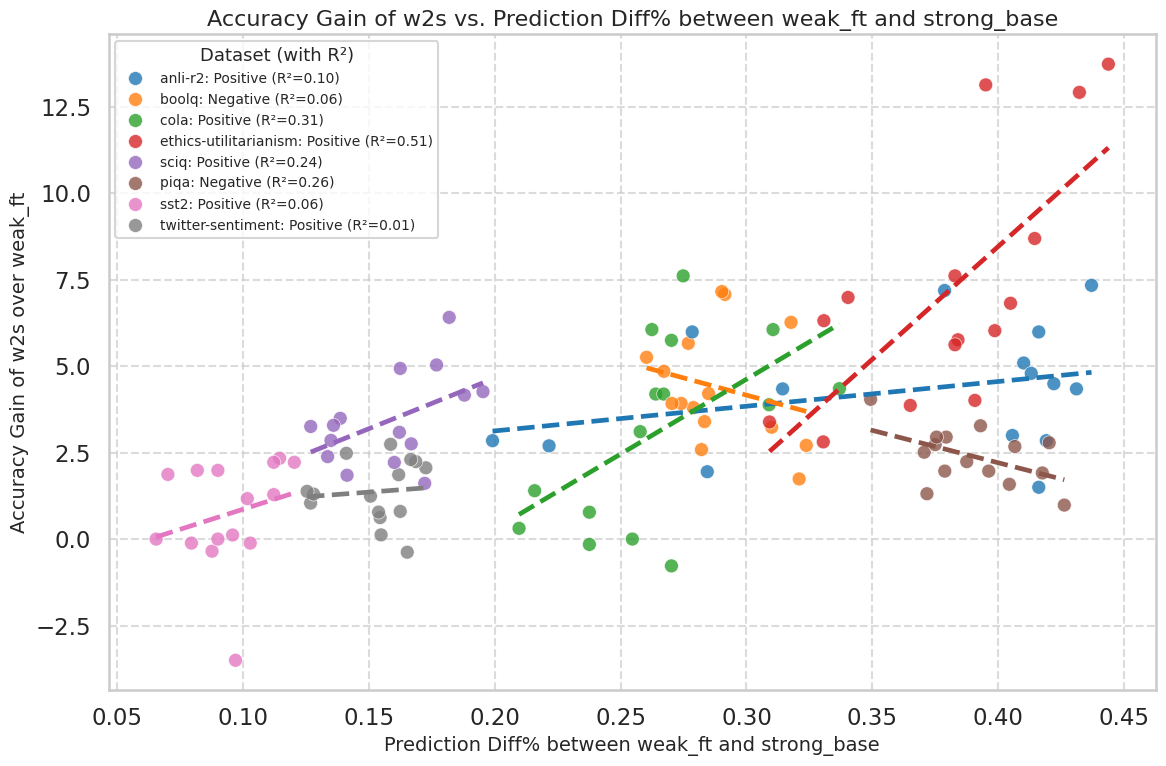

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


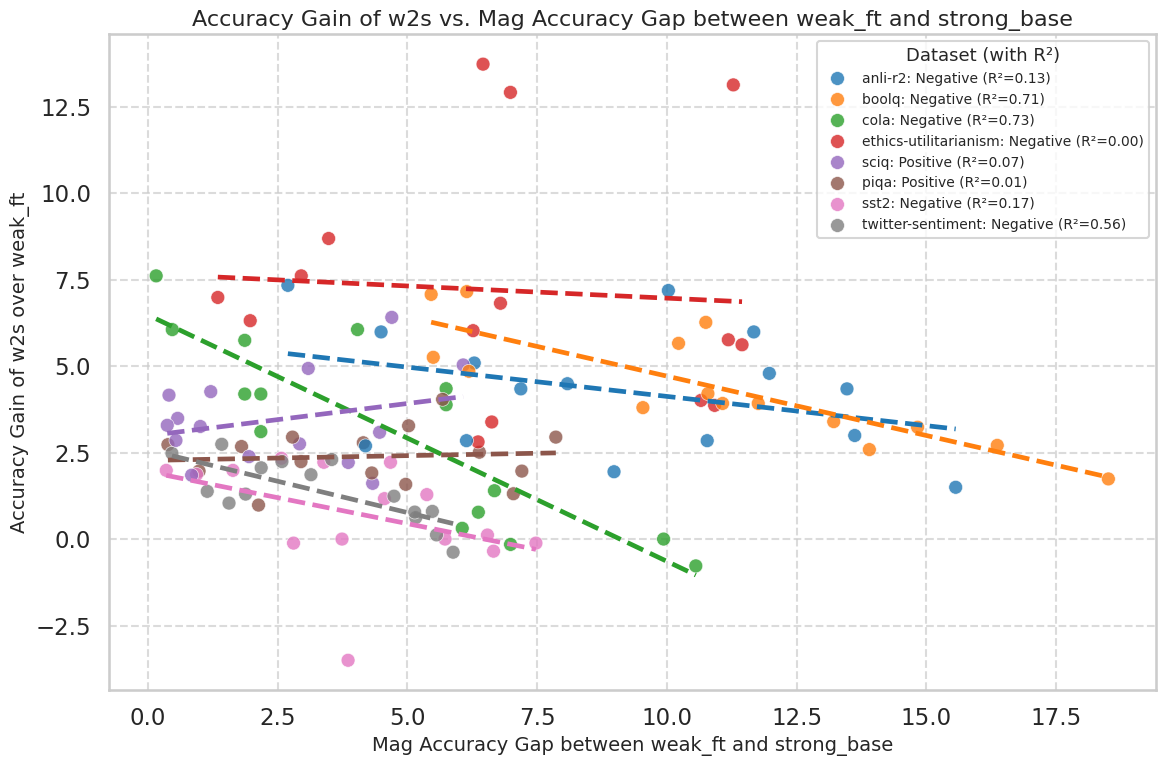

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


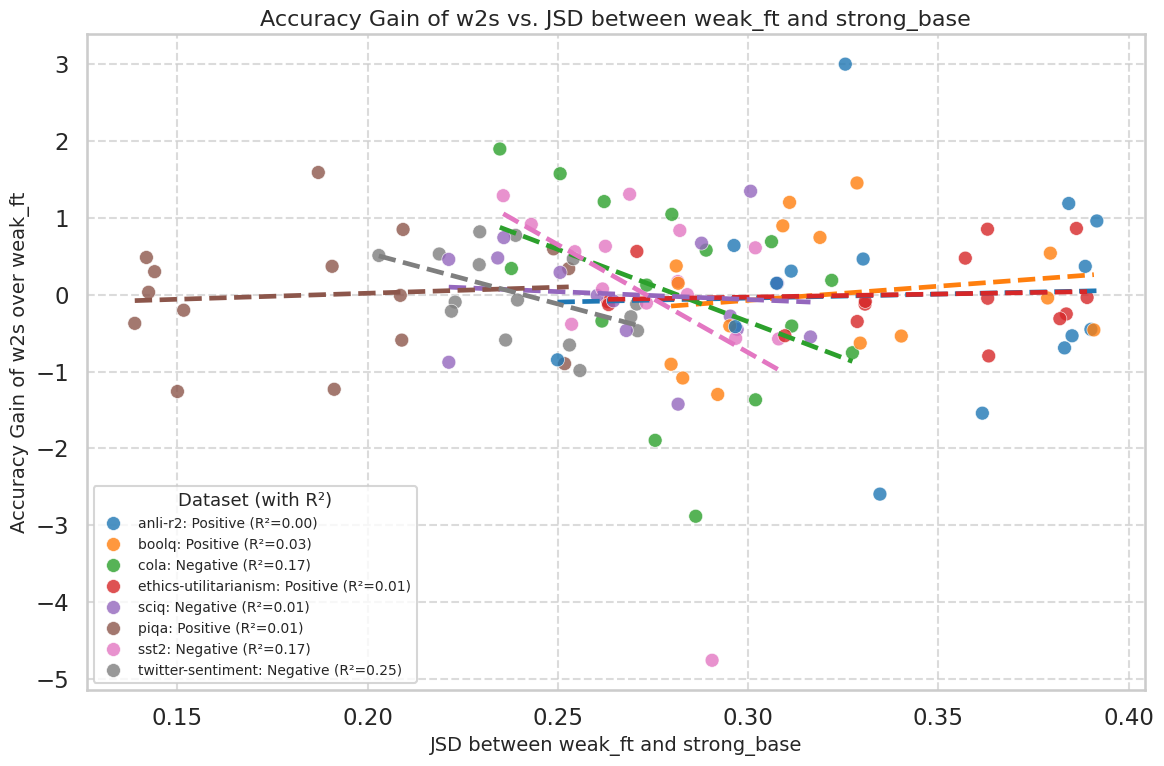

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


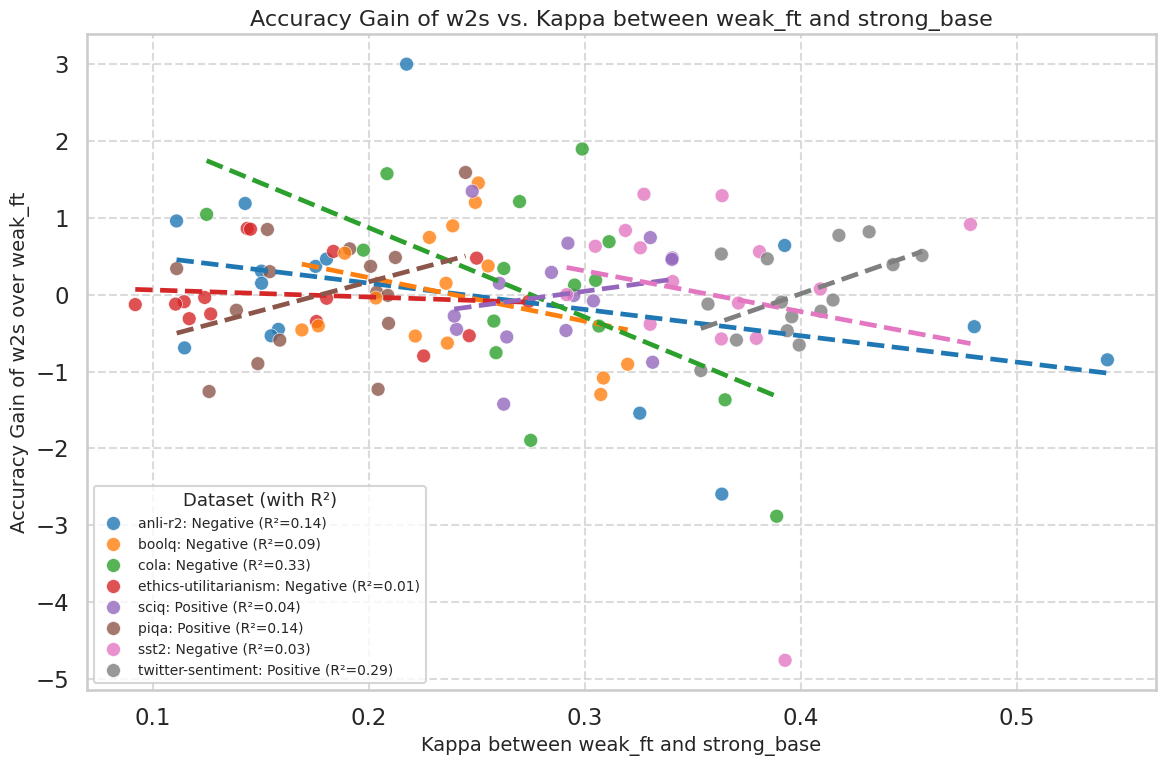

Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


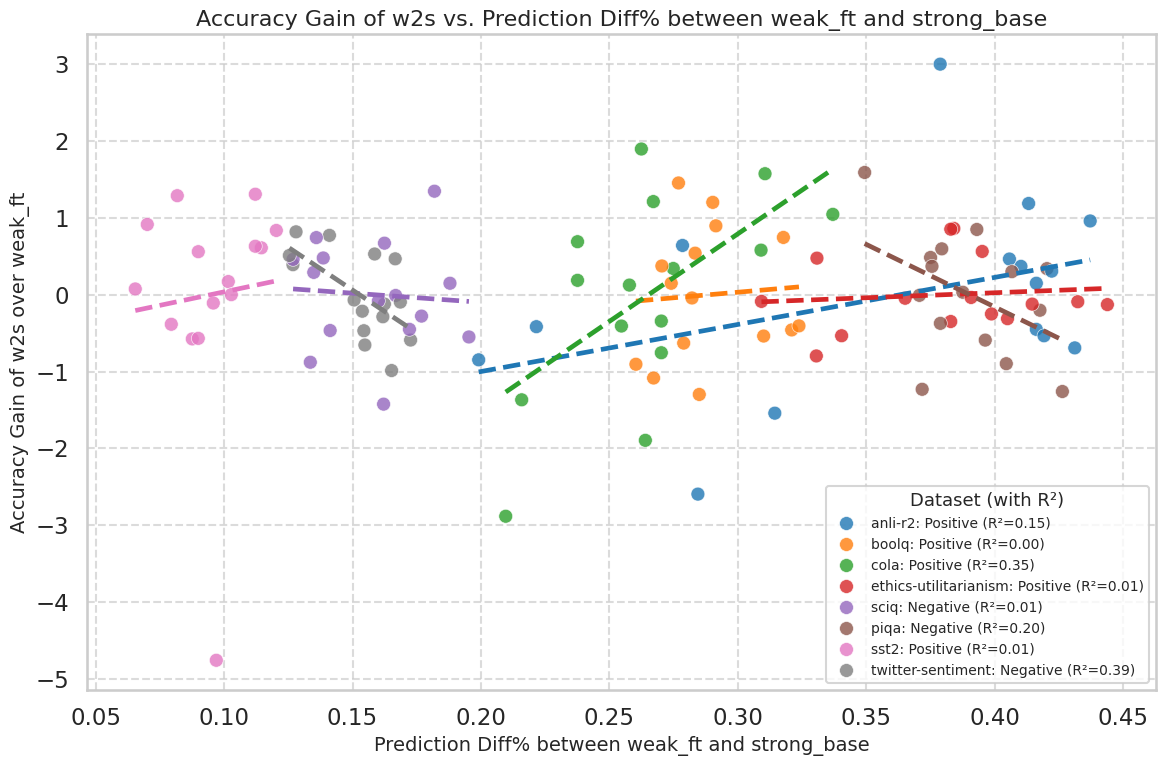

In [8]:
import numpy as np
from sklearn.linear_model import LinearRegression

def make_clean_scatter_plot_by_model_pair(diff, w2sgain, weak_models, strong_models, datasets, diff_func_name):
    df = pd.DataFrame({
        'Difference': diff,
        'W2SGain': w2sgain,
        'WeakModel': weak_models,
        'StrongModel': strong_models,
        'Dataset': datasets
    })

    # Create the figure
    plt.figure(figsize=(12, 8))
    
    # Define color palette and marker styles
    color_palette = sns.color_palette('tab10', len(df['WeakModel'].unique()))
    shape_styles = ['o', 's', 'D', '^', 'v', '<', '>']  # Extend if needed
    weak_model_to_color = {model: color for model, color in zip(df['WeakModel'].unique(), color_palette)}
    strong_model_to_shape = {model: shape for model, shape in zip(df['StrongModel'].unique(), shape_styles)}
    
    # Initialize a dictionary to store R^2 values for the legend
    r2_dict = {}
    
    # Plot each model pair
    for (weak_model, strong_model), group_df in df.groupby(['WeakModel', 'StrongModel']):
        # Fit a linear regression
        X = group_df['Difference'].values.reshape(-1, 1)
        y = group_df['W2SGain'].values
        reg = LinearRegression().fit(X, y)
        r2 = reg.score(X, y)  # R^2 value
        r2_dict[f"{weak_model} vs {strong_model}"] = r2

        # Scatter plot for the group
        plt.scatter(
            group_df['Difference'],
            group_df['W2SGain'],
            color=weak_model_to_color[weak_model],
            marker=strong_model_to_shape[strong_model],
            label=f"{weak_model} vs {strong_model} (R²={r2:.2f})",
            s=100,
            alpha=0.8,
            edgecolor='w',
            linewidth=0.5
        )
        
        # Plot the regression line
        sns.regplot(
            data=group_df,
            x='Difference',
            y='W2SGain',
            scatter=False,
            ci=None,
            line_kws={'color': weak_model_to_color[weak_model], 'linestyle': '--', 'alpha': 0.8}
        )

    # Annotate points with the first letter of the dataset name
    for i in range(len(df)):
        plt.text(
            df['Difference'].iloc[i],
            df['W2SGain'].iloc[i] + 0.1,  # Slight vertical offset for visibility
            df['Dataset'].iloc[i][0:3].upper(),  # First letter of the dataset
            fontsize=9,
            ha='center',
            va='bottom'
        )
    
    # Labels and title
    plt.xlabel(f"{diff_func_name} between weak_ft and strong_base", fontsize=14)
    plt.ylabel("Accuracy Gain of w2s over weak_ft", fontsize=14)
    plt.title(f"Accuracy Gain of w2s vs. {diff_func_name}", fontsize=16)
    
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()
    legend_items = sorted(
        zip(labels, handles),
        key=lambda x: (x[0].split(' vs ')[0], x[0].split(' vs ')[1])  # Sort by weak model, then strong model
    )
    sorted_labels, sorted_handles = zip(*legend_items)
    plt.legend(
        sorted_handles,
        sorted_labels,
        title='Model Pair (with R²)',
        fontsize=10,
        title_fontsize=13,
        loc='upper left',
        bbox_to_anchor=(1.05, 1),  # Place legend outside plot
        borderaxespad=0
    )
    
    # Adjust layout and display
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


def scatter_diff_w2sgain_by_model_pair(accs, diffs, datasets, weak_model, strong_model, m_weak, m_strong_ft, m_w2s, w2sgain=[], diff=[], weak_models=[], strong_models=[], dataset_names=[]):
    for dset in datasets:
        metric_num = accs[dset][m_w2s] - accs[dset][m_weak]
        metric_denom = accs[dset][m_strong_ft] - accs[dset][m_weak]
        metric_denom = 1  # Comment for pgr
        w2sgain.append(metric_num / metric_denom if metric_denom != 0 else 0)
        diff.append(diffs[dset])
        weak_models.append(weak_model)  # Track weak models for coloring
        strong_models.append(strong_model)  # Track strong models for shaping
        dataset_names.append(dset)  # Append dataset names for annotation
    return w2sgain, diff, weak_models, strong_models, dataset_names

Models: Llama-3.1-8B, Llama-3.1-8B
Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.1-8B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: gemma-2-9b, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


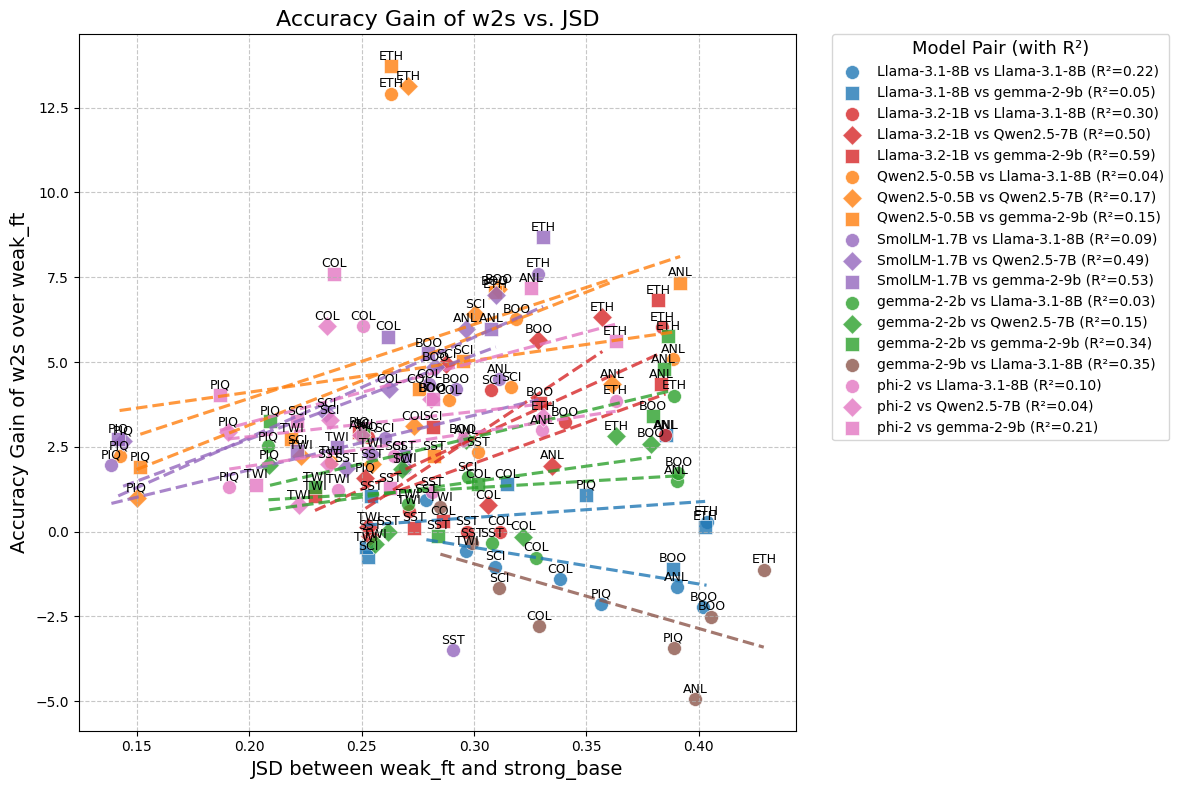

Models: Llama-3.1-8B, Llama-3.1-8B
Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.1-8B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: gemma-2-9b, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


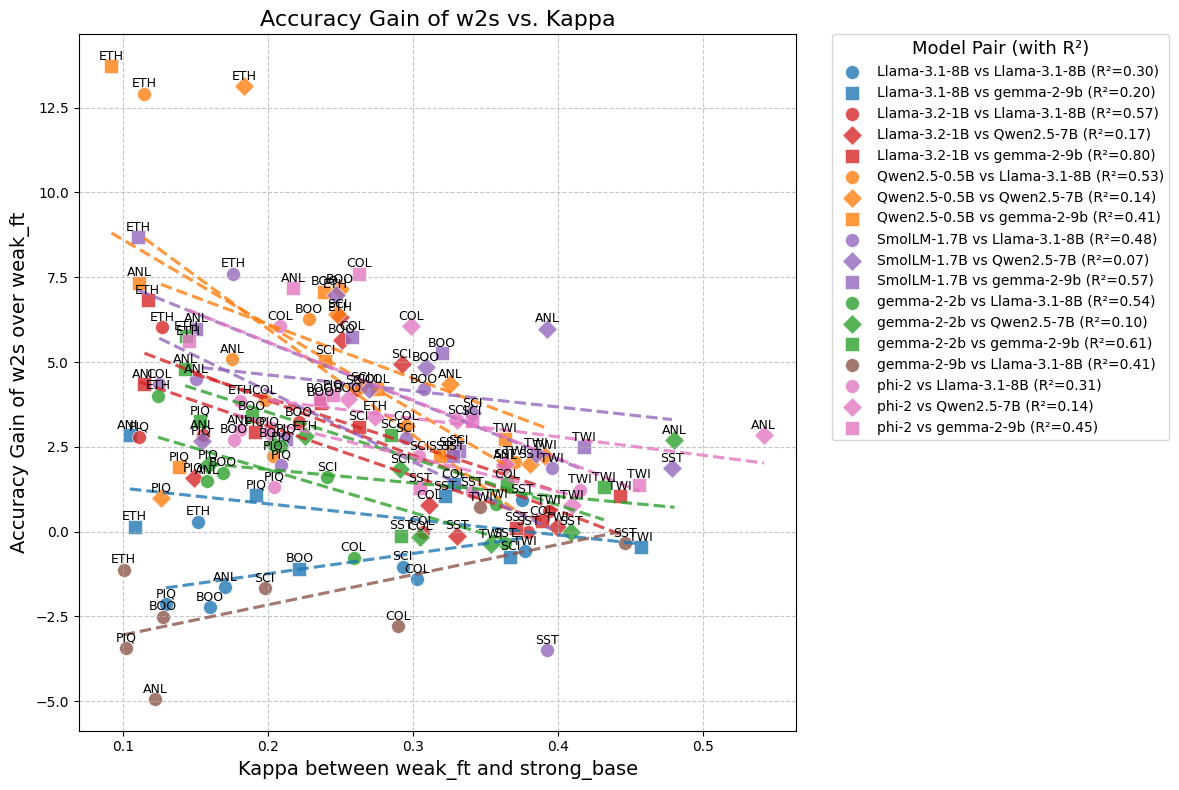

Models: Llama-3.1-8B, Llama-3.1-8B
Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.1-8B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: gemma-2-9b, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


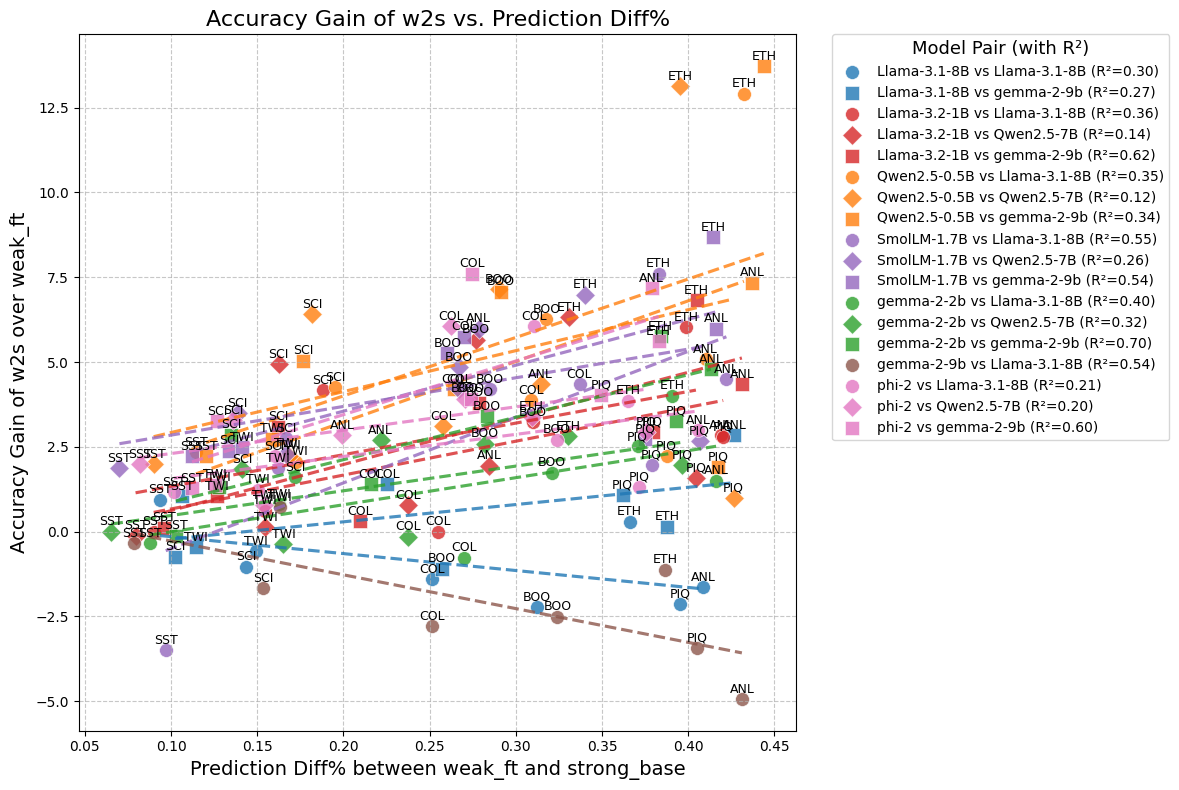

Models: Llama-3.1-8B, Llama-3.1-8B
Models: Qwen2.5-0.5B, Llama-3.1-8B
Models: gemma-2-2b, Llama-3.1-8B
Models: Qwen2.5-0.5B, gemma-2-9b
Models: Llama-3.1-8B, gemma-2-9b
Models: Llama-3.2-1B, Llama-3.1-8B
Models: SmolLM-1.7B, Llama-3.1-8B
Models: gemma-2-9b, Llama-3.1-8B
Models: phi-2, Llama-3.1-8B
Models: Llama-3.2-1B, Qwen2.5-7B
Models: Llama-3.2-1B, gemma-2-9b
Models: Qwen2.5-0.5B, Qwen2.5-7B
Models: SmolLM-1.7B, Qwen2.5-7B
Models: SmolLM-1.7B, gemma-2-9b
Models: gemma-2-2b, gemma-2-9b
Models: phi-2, gemma-2-9b
Models: gemma-2-2b, Qwen2.5-7B
Models: phi-2, Qwen2.5-7B


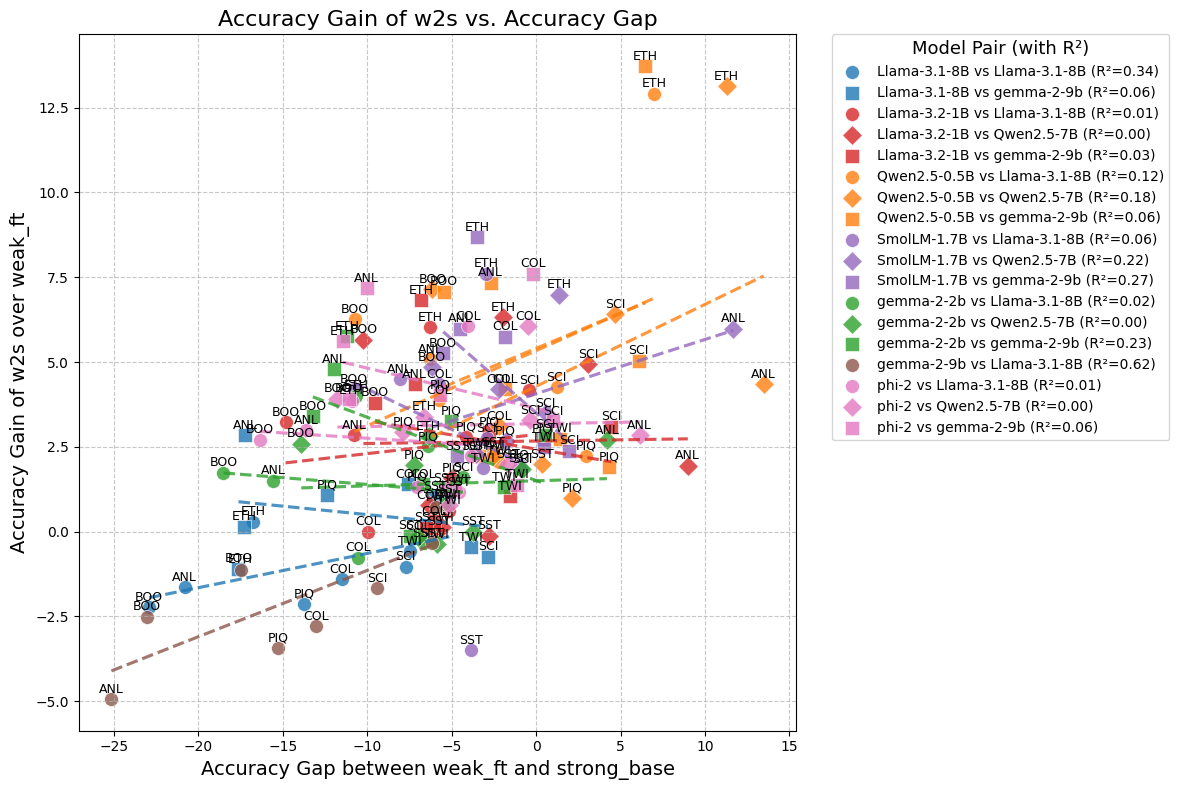

In [8]:
# Updated loop to handle legend-based R^2 values
for metric_func, metric_name in zip([get_jsd, get_kappa_mcqs, get_diffp, _], ["JSD", "Kappa", "Prediction Diff%", "Accuracy Gap"]):
    w2sgain, diff, weak_models, strong_models, dataset_names = [], [], [], [], []
    for (weak_model, strong_model), preds in preds_dict.items():
        model_pair = f"{weak_model} vs {strong_model}"  # Grouping by model pair
        print(f"Models: {weak_model}, {strong_model}")
        acc_test = {dset: precomputed_accs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, model_names, "test") for dset in datasets}
        if metric_name == "Accuracy Gap":
            diff_test = {dset: acc_test[dset]["strong_base"] - acc_test[dset]["weak_ft"] for dset in datasets}
        else:
            diff_test = {dset: precomputed_diffs(preds, f"{folder_name}/{weak_model}___{strong_model}", dset, "test", metric_func, metric_name) for dset in datasets}
        w2sgain, diff, weak_models, strong_models, dataset_names = scatter_diff_w2sgain_by_model_pair(
            acc_test, diff_test, datasets, weak_model, strong_model, "weak_ft", "strong_ft", "w2s", w2sgain, diff, weak_models, strong_models, dataset_names
        )
    make_clean_scatter_plot_by_model_pair(diff, w2sgain, weak_models, strong_models, dataset_names, metric_name)

In [16]:
# linear regression of weak_ft, strong_base probabilities on w2s probabilities
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def linear_regression(dset_preds, datasets, m1name, m2name, m3name):
    def get_probs(preds):
        return np.array([pred['probs'] for pred in preds])
    
    # Initialize the linear regression model
    reg = LinearRegression()
    
    # Initialize lists to hold the MSE values for each dataset
    mse_values = []

    # Perform linear regression for each dataset
    for dset in datasets:
        # Get the predictions for each model
        weak_ft_probs = get_probs(dset_preds[dset][m1name])
        strong_base_probs = get_probs(dset_preds[dset][m2name])
        w2s_probs = get_probs(dset_preds[dset][m3name])
        
        # Fit the linear regression model
        reg.fit(w2s_probs, weak_ft_probs)
        
        # Predict the weak_ft probabilities using w2s probabilities
        weak_ft_pred = reg.predict(w2s_probs)
        
        # Calculate the MSE between the predicted and actual weak_ft probabilities
        mse = mean_squared_error(weak_ft_probs, weak_ft_pred)
        mse_values.append(mse)

    # Plot the MSE values for each dataset
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(datasets, mse_values, color='skyblue')
    ax.set_xlabel('Dataset', fontsize=12)
    ax.set_ylabel('Mean Squared Error', fontsize=12)
    ax.set_title('Mean Squared Error of Weak Fine-Tune Predictions', fontsize=14, fontweight='bold')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    

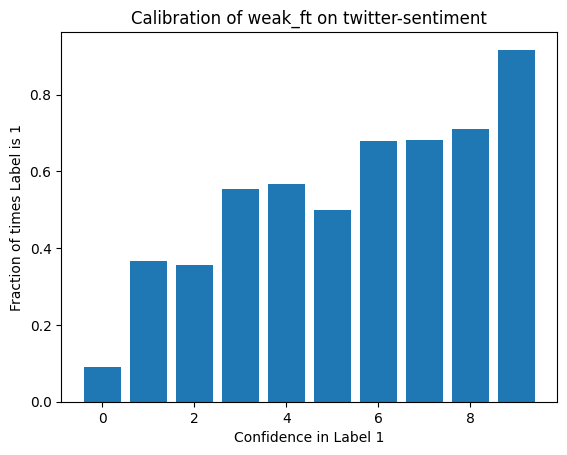

In [5]:
#plot accuracy vs confidence histogram for model
def calibration_histogram(preds, dset, mname, split='test'):
    ds = preds[dset][mname][split]
    #collect accuracies in each confidence bucket
    bucket_accs = {i: 0 for i in range(10)}
    bucket_totals = {i: 0 for i in range(10)}
    for pred in ds:
        conf = pred["soft_pred"]
        bucket = int(conf * 10)
        bucket = min(bucket, 9)
        bucket_totals[bucket] += 1
        bucket_accs[bucket] += pred["labels"]

    bucket_accs = {i: bucket_accs[i] / bucket_totals[i] if bucket_totals[i] > 0 else 0 for i in range(10)}
    plt.bar(bucket_accs.keys(), bucket_accs.values())
    plt.xlabel("Confidence in Label 1")
    plt.ylabel("Fraction of times Label is 1")
    plt.title(f"Calibration of {mname} on {dset}")
    plt.show()

calibration_histogram(preds, "twitter-sentiment", "weak_ft")

# #check calibation of models
# def get_brier(ds):
#     labels = np.array([d["labels"] for d in ds])
#     preds = np.array([d["soft_pred"] for d in ds])
#     return np.mean((labels - preds)**2)

# for dset in datasets:
#     for mname in model_names:
#         print(f"{dset} {mname} Brier: {get_brier(preds[dset][mname]['test']):.4f}")